In [1]:
import numpy as np
import scipy.io as sio 
import scipy.signal as sig
from matplotlib import pyplot as plt
%matplotlib inline
import random 
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, Normalizer
import tensorflow 
from tensorflow import keras
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Reshape, Conv1D
from tensorflow.keras.regularizers import l2
import seaborn as sns

np.random.seed(0)

In [8]:
dat = [sio.loadmat(f'Data/BCICIV_4_mat/sub{x}_comp.mat',struct_as_record=True) for x in range(1,4)]
tdat = [sio.loadmat(f'Data/sub{x}_testlabels.mat',struct_as_record=True) for x in range(1,4)]

train_data = [dat[x]['train_data'] for x in range(3)]
test_data = ([dat[x]['test_data'] for x in range(3) ])
train_dg = ([dat[x]['train_dg'] for x in range(3) ])
test_dg = ([tdat[x]['test_dg'] for x in range(3) ])

train_samples = [train_data[i].shape[0] for i in range(3)]
channels = [train_data[i].shape[1] for i in range(3)]
test_samples = [test_data[i].shape[0] for i in range(3)]
channel_train_data = [np.transpose(train_data[i],(1,0)) for i in range(3)]
channel_test_data = [np.transpose(test_data[i],(1,0)) for i in range(3)]
finger_train_data = [np.transpose(train_dg[i],(1,0)) for i in range(3)]
finger_test_data = [np.transpose(test_dg[i],(1,0)) for i in range(3)]

sampling_frequency = 1000

In [ ]:
def assign_states(finger_data):
    # State assignment : (0 : rest, 1-5 finger flexed)
    dsamples = len(finger_data[0])
    states = [None]*dsamples
    threshold_1,threshold_2  = 2.0,1.0
    for i in range(dsamples):
        flex,rest = 0,0
        for j in range(5):
            if finger_data[j][i] >= threshold_1:
                states[i] = j + 1
                flex += 1
            elif finger_data[j][i] < threshold_2:
                rest += 1
        if states[i] == None:
            if rest:
                states[i] = 0

    return states

def AM(signal):
    cur = 0
    output = []
    for i in range(len(signal)):
        if(i and i % 40 == 0):
            output.append(cur)
            cur = 0
        cur += signal[i]**2
    output.append(cur)
         
    return output

In [9]:
# Merge data for all subjects
merch_train = []
merch_test = []
for i in range(max(channels)):
    merch = []
    for c in range(len(channel_train_data)):
        if(i >= channels[c]):
            for j in range(train_samples[c]):
                merch.append(0)
        else:
            for val in channel_train_data[c][i]:
                merch.append(val)
    merch_train.append(merch)

for i in range(max(channels)):
    merch = []
    for c in range(len(channel_test_data)):
        if(i >= channels[c]):
            for j in range(test_samples[c]):
                merch.append(0)
        else:
            for val in channel_test_data[c][i]:
                merch.append(val)
    merch_test.append(merch)

merf_train = []
for i in range(5):
    merf = []
    for f in finger_train_data:
        for val in f[i]:
            merf.append(val)
    merf_train.append(merf)

merf_test = []
for i in range(5):
    merf = []
    for f in finger_test_data:
        for val in f[i]:
            merf.append(val)
    merf_test.append(merf)

# Finger data downsampling  
merf_train_ds = [None]*5
for i in range(5):
    merf_train_ds[i] = [merf_train[i][j] for j in range(0,len(merf_train[i]),40)]

merf_test_ds = [None]*5
for i in range(5):
    merf_test_ds[i] = [merf_test[i][j] for j in range(0,len(merf_test[i]),40)]

merf_train_states = assign_states(merf_train_ds)
merf_test_states = assign_states(merf_test_ds)

train_full_band = [AM(x) for x in merch_train]
test_full_band = [AM(x) for x in merch_test]

trc = np.array(train_full_band).T
trf = np.array(merf_train_states)

tec = np.array(test_full_band).T
tef = np.array(merf_test_states)

# Finger One-Hot Encoding
trf = trf.reshape(len(trf), 1)
trf = OneHotEncoder(sparse=False).fit_transform(trf)

tef = tef.reshape(len(tef), 1)
tef = OneHotEncoder(sparse=False).fit_transform(tef)

# ECoG Normalization
trc = Normalizer().fit(trc).transform(trc)
tec = Normalizer().fit(tec).transform(tec)

# Reshape to 3D Structure
trc = trc.reshape(len(trc),1,len(trc[0]))
tec = tec.reshape(len(tec),1,len(tec[0]))

# Storing Non Hot-Encoded
tr_finger_nonhotencoded = np.argmax(trf,axis=1)
te_finger_nonhotencoded = np.argmax(tef,axis=1)

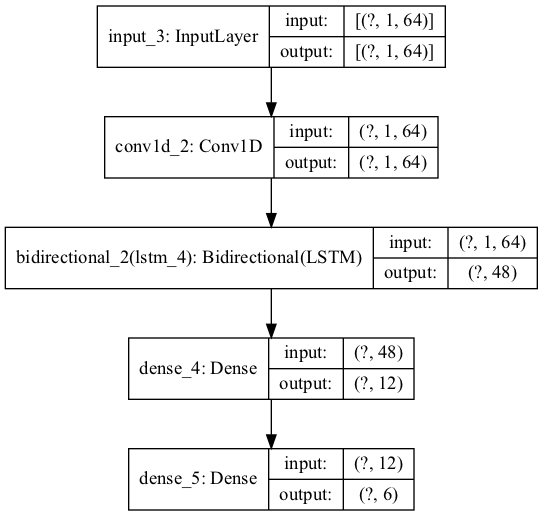

In [26]:
# MODEL
input = keras.Input(shape=(1,64))
conv = Conv1D(64, 1, activation='relu')
layer = conv(input)
forward_layer = LSTM(24, activation='relu')
backward_layer = LSTM(24, activation='relu', go_backwards=True)
layer = Bidirectional(forward_layer, backward_layer=backward_layer)(layer)
layer = Dense(12, activation='relu')(layer)
output = Dense(6, activation='softmax')(layer)
model = keras.Model(inputs=input, outputs=output, name="CNN-BiLSTM-BCI")
keras.utils.plot_model(model, "CNN-BiLSTM-BCI.png", show_shapes=True)

In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.005)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['mae','mse'])
model.summary()

history = model.fit(trc, trf, batch_size = 10, epochs=100, validation_split=0.05)

predictions_tr = model.predict(trc)
predictions_te = model.predict(tec)
predictions_tr = np.argmax(predictions_tr, axis = 1)
predictions_te = np.argmax(predictions_te, axis = 1)

print("Train accuracy : ",accuracy_score(tr_finger_nonhotencoded, predictions_tr))
print("Test accuracy : ",accuracy_score(te_finger_nonhotencoded, predictions_te))